In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
from plotnine import *

<IPython.core.display.Javascript object>

In [4]:
pop = pd.read_csv("../20_intermediate_files/cleaned_population.csv")
death_rate = pd.read_csv("../20_intermediate_files/death_rate.csv")
opioids = pd.read_csv("../20_intermediate_files/opioids_clean.csv")

<IPython.core.display.Javascript object>

In [5]:
opioids = (
    opioids.groupby(["state", "county", "Year"], as_index=False)
    .sum()
    .drop(["Month"], axis=1)
)

<IPython.core.display.Javascript object>

In [6]:
pop.rename(columns={"year": "Year"}, inplace=True)

<IPython.core.display.Javascript object>

In [7]:
# Additional data cleaning before merge
## Additional treatment for overdose deaths dataset
death_rate["state"] = death_rate["state"].str.lstrip()
death_rate["county"] = death_rate["county"].str.rstrip()

death_rate = death_rate[(death_rate["state"] != "DC") | (death_rate["state"] != "AK")]

death_rate = death_rate.loc[death_rate["Deaths"] != "Missing"]

## Additional treatment for population dataset
pop = pop[(pop["Year"] >= 2003) & (pop["Year"] <= 2015)]

<IPython.core.display.Javascript object>

In [8]:
# Change the data type of death_rate.Deaths, str to float
death_rate.Deaths = death_rate.Deaths.astype(float)

<IPython.core.display.Javascript object>

In [9]:
# opioids_year = opioids.groupby(["Year","state"]).sum()['weight'].reset_index()
# death_year = death_rate.groupby(["Year","state"]).sum()['Deaths'].reset_index()
# pop_year = pop.groupby(["Year","state"]).sum()['total_population'].reset_index()

<IPython.core.display.Javascript object>

In [10]:
# Merge
pop_opi = pop.merge(opioids, on=["Year", "state", "county"], how="left")
final = pop_opi.merge(death_rate, on=["state", "Year", "county"], how="left")

<IPython.core.display.Javascript object>

In [11]:
final.loc[(final.Year >= 2006) & (final.Year <= 2012)].weight.isna().any()

True

<IPython.core.display.Javascript object>

In [12]:
final["opioid_per_cap"] = final["weight"] / final["total_population"]
final["mortality_rate_in_100k"] = final["Deaths"] / final["total_population"] * 100000

<IPython.core.display.Javascript object>

In [13]:
final.fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [14]:
# final.groupby(["Year"]).mean()

<IPython.core.display.Javascript object>

-------------

## Plotting

In [15]:
northeast = ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"]
midwest = ["IL", "IN", "MI", "OH", "WI", "IA", "KS", "MN", "MO", "NE", "ND", "SD"]
south = [
    "DE",
    "FL",
    "GA",
    "MD",
    "NC",
    "SC",
    "VA",
    "WV",
    "AL",
    "KY",
    "MS",
    "TN",
    "AR",
    "LA",
    "OK",
    "TX",
]
west = ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY", "CA", "HI", "OR", "WA"]

<IPython.core.display.Javascript object>

### Florida

In [16]:
control = ["GA", "MD", "NC", "LA", "VA", "AL", "MS", "AR", "OK", "SC"]

<IPython.core.display.Javascript object>

In [17]:
# control_df = final[final.state.isin(control)].groupby(["Year"], as_index = False).mean()

<IPython.core.display.Javascript object>

In [18]:
control_df = final[final.state.isin(control)]

control_df = control_df.copy()
control_df["state"] = "control"

<IPython.core.display.Javascript object>

In [19]:
fl_df = pd.concat([final[final["state"] == "FL"], control_df]).reset_index(drop=True)
# fl_df["Year"] = pd.to_datetime(fl_df["Year"],format = "%Y")

<IPython.core.display.Javascript object>

In [20]:
# fl_df.groupby(["state", "Year"]).mean()

<IPython.core.display.Javascript object>

In [21]:
fl_df["policy"] = 0
fl_df.loc[fl_df["Year"] > 2010, "policy"] = 1

<IPython.core.display.Javascript object>

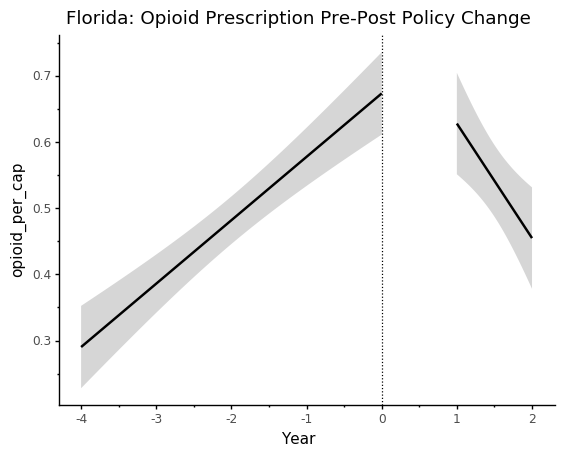

<ggplot: (8773124392237)>

<IPython.core.display.Javascript object>

In [23]:
(
    ggplot(
        fl_df[fl_df["state"] == "FL"],
        aes(x="Year", y="opioid_per_cap", group="policy"),
    )
    + geom_smooth(method="lm")
    + geom_vline(xintercept=2010, linetype="dotted")
    + ggtitle("Florida: Opioid Prescription Pre-Post Policy Change")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
        ],
        labels=["-4", "-3", "-2", "-1", "0", "1", "2"],
        limits=(2006, 2012),
    )
    + theme_classic()
)

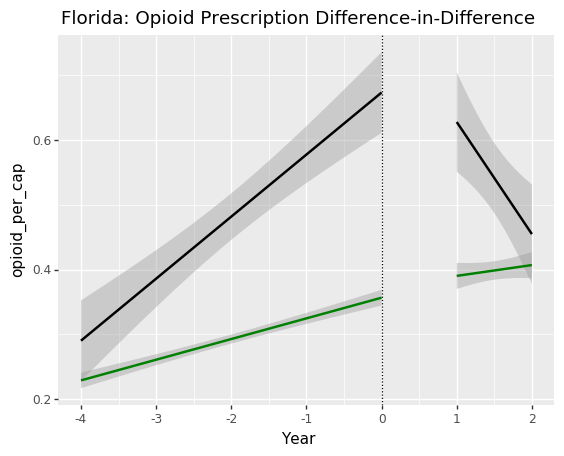

<ggplot: (8773124681945)>

<IPython.core.display.Javascript object>

In [24]:
(
    ggplot(fl_df, aes(x = "Year", y = "opioid_per_cap", group = "policy"))
    + geom_smooth(
        fl_df[fl_df["state"] == "FL"],
        aes(x="Year", y="opioid_per_cap", group="policy"),
        method="lm",
    )
    + geom_smooth(
        fl_df[fl_df["state"] == "control"],
        aes(x="Year", y="opioid_per_cap", group="policy"),
        method="lm",
        color="green",
    )
    + geom_vline(xintercept=2010, linetype="dotted")
    + ggtitle("Florida: Opioid Prescription Difference-in-Difference")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
        ],
        labels=["-4", "-3", "-2", "-1", "0", "1", "2"],
        limits=(2006, 2012),
    )
    + scale_color_manual(
        name="regression",
        values={"opioid_per_cap": "black", "opioid_per_cap": "green"},
    )
)

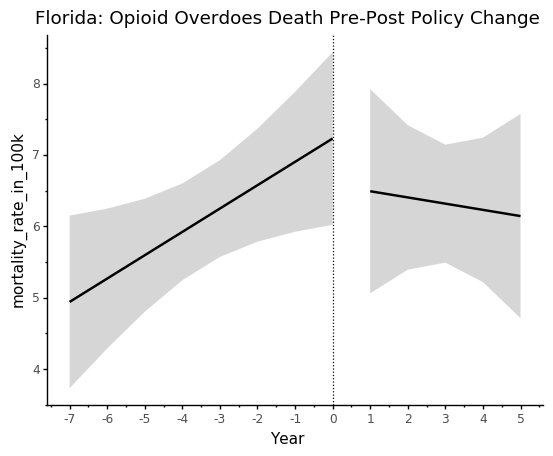

<ggplot: (8773124458973)>

<IPython.core.display.Javascript object>

In [25]:
(
    ggplot(fl_df[fl_df["state"] == "FL"])
    + geom_smooth(
        aes(x="Year", y="mortality_rate_in_100k", group="policy"), method="lm"
    )
    + geom_vline(xintercept=2010, linetype="dotted")
    + ggtitle("Florida: Opioid Overdoes Death Pre-Post Policy Change")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2003,
            2004,
            2005,
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
        ],
        labels=["-7", "-6", "-5", "-4", "-3", "-2", "-1", "0", "1", "2", "3", "4", "5"],
    )
    + theme_classic()
)

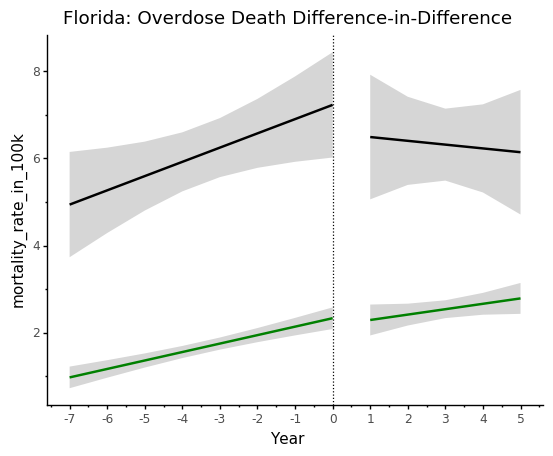

<ggplot: (8784592592477)>

<IPython.core.display.Javascript object>

In [57]:
(
    ggplot(fl_df)
    + geom_smooth(
        fl_df[fl_df["state"] == "FL"],
        aes(x="Year", y="mortality_rate_in_100k", group="policy"),
        method="lm",
    )
    + geom_smooth(
        fl_df[fl_df["state"] == "control"],
        aes(x="Year", y="mortality_rate_in_100k", group="policy"),
        method="lm",
        color="green",
    )
    + geom_vline(xintercept=2010, linetype="dotted")
    + ggtitle("Florida: Overdose Death Difference-in-Difference")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2003,
            2004,
            2005,
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
        ],
        labels=["-7", "-6", "-5", "-4", "-3", "-2", "-1", "0", "1", "2", "3", "4", "5"],
    )
    + theme_classic()
)

### Texas

In [26]:
control = ["KS", "ME", "MS", "MT", "SD"]

control_df = final[final.state.isin(control)]

control_df = control_df.copy()
control_df["state"] = "control"

<IPython.core.display.Javascript object>

In [27]:
tx_df = pd.concat([final[final["state"] == "TX"], control_df]).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [28]:
# tx_df.groupby(["state", "Year"]).mean()

<IPython.core.display.Javascript object>

In [29]:
tx_df["policy"] = 0
tx_df.loc[tx_df["Year"] > 2007, "policy"] = 1

<IPython.core.display.Javascript object>

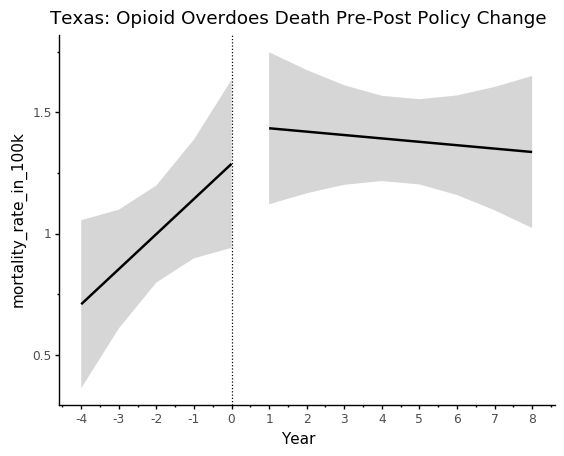

<ggplot: (8773124687261)>

<IPython.core.display.Javascript object>

In [31]:
(
    ggplot(tx_df[tx_df["state"] == "TX"])
    + geom_smooth(
        aes(x="Year", y="mortality_rate_in_100k", group="policy"), method="lm"
    )
    + geom_vline(xintercept=2007, linetype="dotted")
    + ggtitle("Texas: Opioid Overdoes Death Pre-Post Policy Change")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2003,
            2004,
            2005,
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
        ],
        labels=["-4", "-3", "-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
    )
    + theme_classic()
)

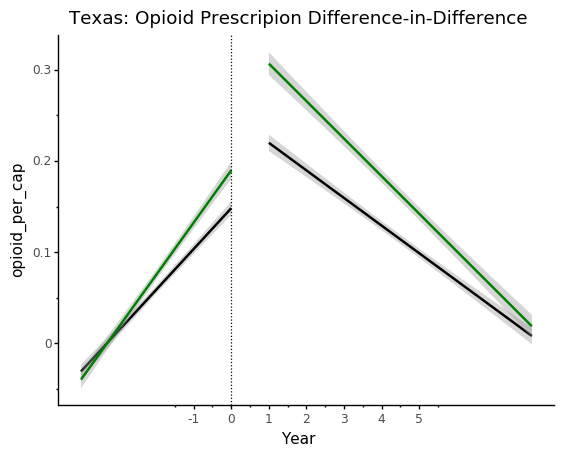

<ggplot: (8773126847717)>

<IPython.core.display.Javascript object>

In [56]:
(
    ggplot(tx_df)
    + geom_smooth(
        tx_df[tx_df["state"] == "TX"],
        aes(x="Year", y="opioid_per_cap", group="policy"),
        method="lm",
    )
    + geom_smooth(
        tx_df[tx_df["state"] == "control"],
        aes(x="Year", y="opioid_per_cap", group="policy"),
        method="lm",
        color="green",
    )
    + geom_vline(xintercept=2007, linetype="dotted")
    + ggtitle("Texas: Opioid Prescripion Difference-in-Difference")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012
        ],
        labels=["-1", "0", "1", "2", "3", "4", "5"],
    )
    + theme_classic()
)

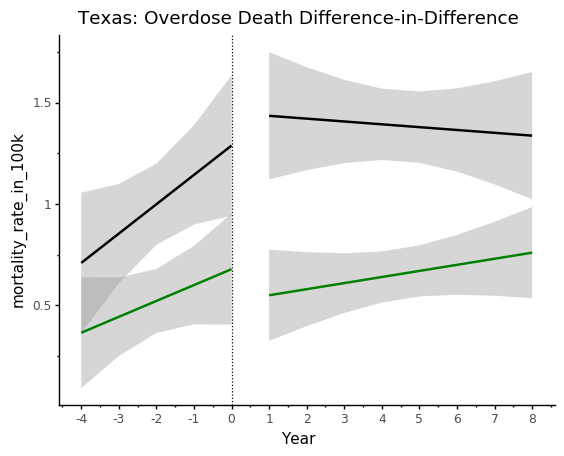

<ggplot: (8773125071109)>

<IPython.core.display.Javascript object>

In [32]:
(
    ggplot(tx_df)
    + geom_smooth(
        tx_df[tx_df["state"] == "TX"],
        aes(x="Year", y="mortality_rate_in_100k", group="policy"),
        method="lm",
    )
    + geom_smooth(
        tx_df[tx_df["state"] == "control"],
        aes(x="Year", y="mortality_rate_in_100k", group="policy"),
        method="lm",
        color="green",
    )
    + geom_vline(xintercept=2007, linetype="dotted")
    + ggtitle("Texas: Overdose Death Difference-in-Difference")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2003,
            2004,
            2005,
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
        ],
        labels=["-4", "-3", "-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
    )
    + theme_classic()
)

### Washington

In [36]:
control = ["MD", "MT", "NC", "OR", "WI", "SC", "LA"]
control_df = final[final.state.isin(control)]
control_df = control_df.copy()
control_df["state"] = "control"


<IPython.core.display.Javascript object>

In [37]:
wa_df = pd.concat([final[final["state"] == "WA"], control_df]).reset_index(drop=True)
wa_df["policy"] = 0
wa_df.loc[wa_df["Year"] > 2012, "policy"] = 1

<IPython.core.display.Javascript object>

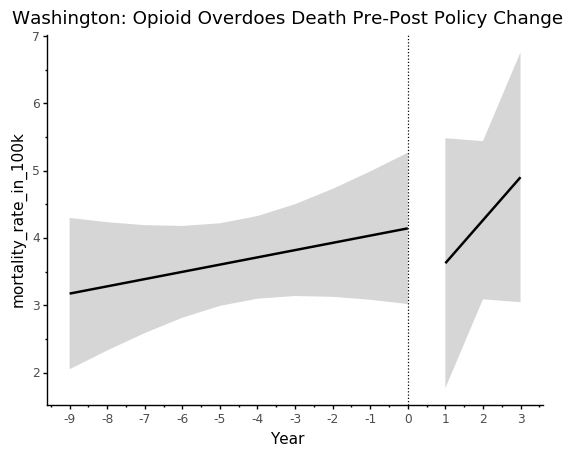

<ggplot: (8784590739605)>

<IPython.core.display.Javascript object>

In [33]:
(
    ggplot(wa_df[wa_df["state"] == "WA"])
    + geom_smooth(
        aes(x="Year", y="mortality_rate_in_100k", group="policy"), method="lm"
    )
    + geom_vline(xintercept=2012, linetype="dotted")
    + ggtitle("Washington: Opioid Overdoes Death Pre-Post Policy Change")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2003,
            2004,
            2005,
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
        ],
        labels=[
            "-9",
            "-8",
            "-7",
            "-6",
            "-5",
            "-4",
            "-3",
            "-2",
            "-1",
            "0",
            "1",
            "2",
            "3",
        ],
    )
    + theme_classic()
)

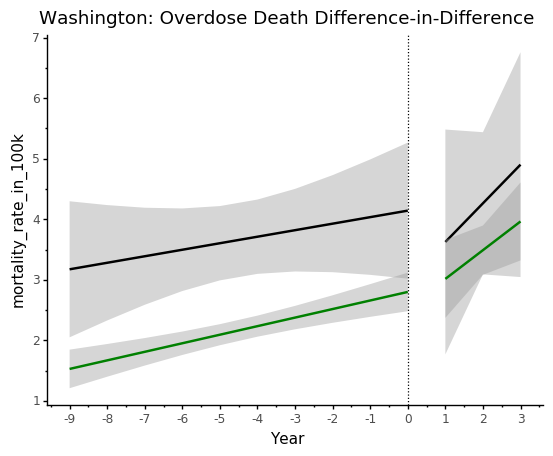

<ggplot: (8784592078209)>

<IPython.core.display.Javascript object>

In [34]:
(
    ggplot(wa_df)
    + geom_smooth(
        wa_df[wa_df["state"] == "WA"],
        aes(x="Year", y="mortality_rate_in_100k", group="policy"),
        method="lm",
    )
    + geom_smooth(
        wa_df[wa_df["state"] == "control"],
        aes(x="Year", y="mortality_rate_in_100k", group="policy"),
        method="lm",
        color="green",
    )
    + geom_vline(xintercept=2012, linetype="dotted")
    + ggtitle("Washington: Overdose Death Difference-in-Difference")
    + scale_x_continuous(
        name="Year",
        breaks=[
            2003,
            2004,
            2005,
            2006,
            2007,
            2008,
            2009,
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
        ],
        labels=[
            "-9",
            "-8",
            "-7",
            "-6",
            "-5",
            "-4",
            "-3",
            "-2",
            "-1",
            "0",
            "1",
            "2",
            "3",
        ],
    )
    + theme_classic()
)

------

## Selecting Control States

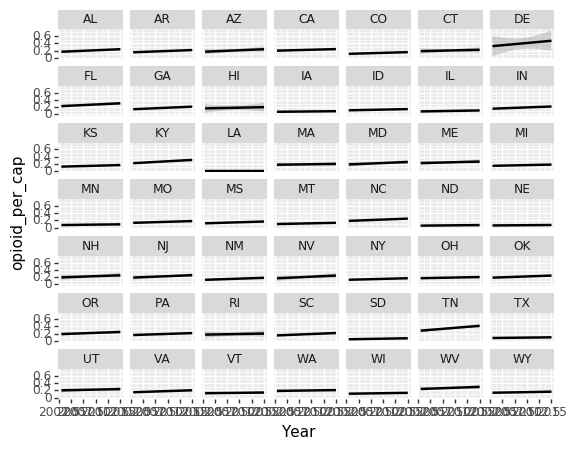

<ggplot: (8784591032913)>

<IPython.core.display.Javascript object>

In [35]:
(
    ggplot(final)
    + geom_smooth(aes(x="Year", y="opioid_per_cap"), method="lm")
    + facet_wrap("~state")
)

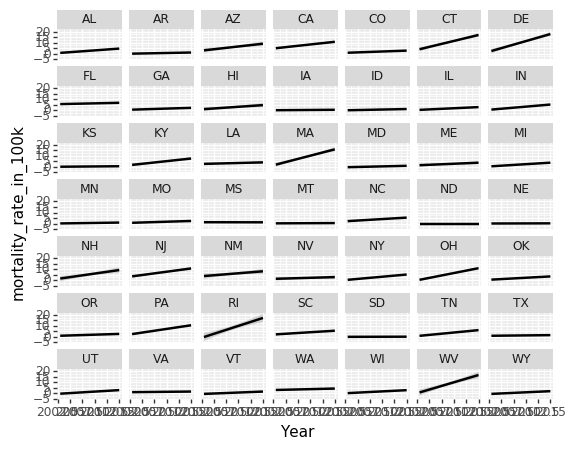

<ggplot: (8784596976769)>

<IPython.core.display.Javascript object>

In [36]:
(
    ggplot(final)
    + geom_smooth(aes(x="Year", y="mortality_rate_in_100k"), method="lm")
    + facet_wrap("~state")
)

In [37]:
# Florida
south = [
    "DE",
    "FL",
    "GA",
    "MD",
    "NC",
    "SC",
    "VA",
    "WV",
    "AL",
    "KY",
    "MS",
    "TN",
    "AR",
    "LA",
    "OK",
    "TX",
]
# "CO",  "IA", "ID", "IL", "LA",

control = ["GA", "MD", "NC", "LA", "VA", "AL", "MS", "AR", "OK", "SC"]

<IPython.core.display.Javascript object>

In [38]:
# Texas
control = ["VA", "MS", "AR"]
control = ["KS", "ME", "MS", "MT", "SD", "LA", "CO"]

# Washington
control = ["MD", "MT", "NC", "OR", "WI", "SC", "LA", "OR", "NC"]

<IPython.core.display.Javascript object>